In [1]:
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.9 MB/s eta 0:00:00


In [2]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [4]:
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 11.1 MB/s eta 0:00:00


In [5]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017_2223/main/datasets/bike.csv'
bike = pd.read_csv(url)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [6]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [7]:
for column in bike.columns:
  if bike[column].dtype == 'object':
    unique_values = bike[column].unique()
    print(f"{column}: {unique_values}")

season: ['WINTER' 'SPRING' 'SUMMER' 'FALL']
mnth: ['JAN' 'FEB' 'MAR' 'APR' 'MAY' 'JUN' 'JUL' 'AUG' 'SEP' 'OCT' 'NOV' 'DEC']
holiday: ['NO HOLIDAY' 'HOLIDAY']
weekday: ['SAT' 'SUN' 'MON' 'TUE' 'WED' 'THU' 'FRI']
workingday: ['NO WORKING DAY' 'WORKING DAY']
weathersit: ['MISTY' 'GOOD' 'RAIN/SNOW/STORM']


In [70]:
X = bike.drop(columns = 'cnt')
y = bike['cnt']

In [71]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=0
#     )

X.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,4


In [72]:
bike['yr'].unique()

array([2011, 2012])

In [73]:
X.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'days_since_2011'],
      dtype='object')

In [74]:
bin_cat = ['holiday', 'workingday']
tar_cat = ['season', 'mnth', 'weekday', 'weathersit']
num = ['yr', 'temp', 'hum', 'windspeed', 'days_since_2011' ]

In [75]:
X.select_dtypes(exclude='object').columns.tolist()

['yr', 'temp', 'hum', 'windspeed', 'days_since_2011']

<Axes: xlabel='windspeed', ylabel='Count'>

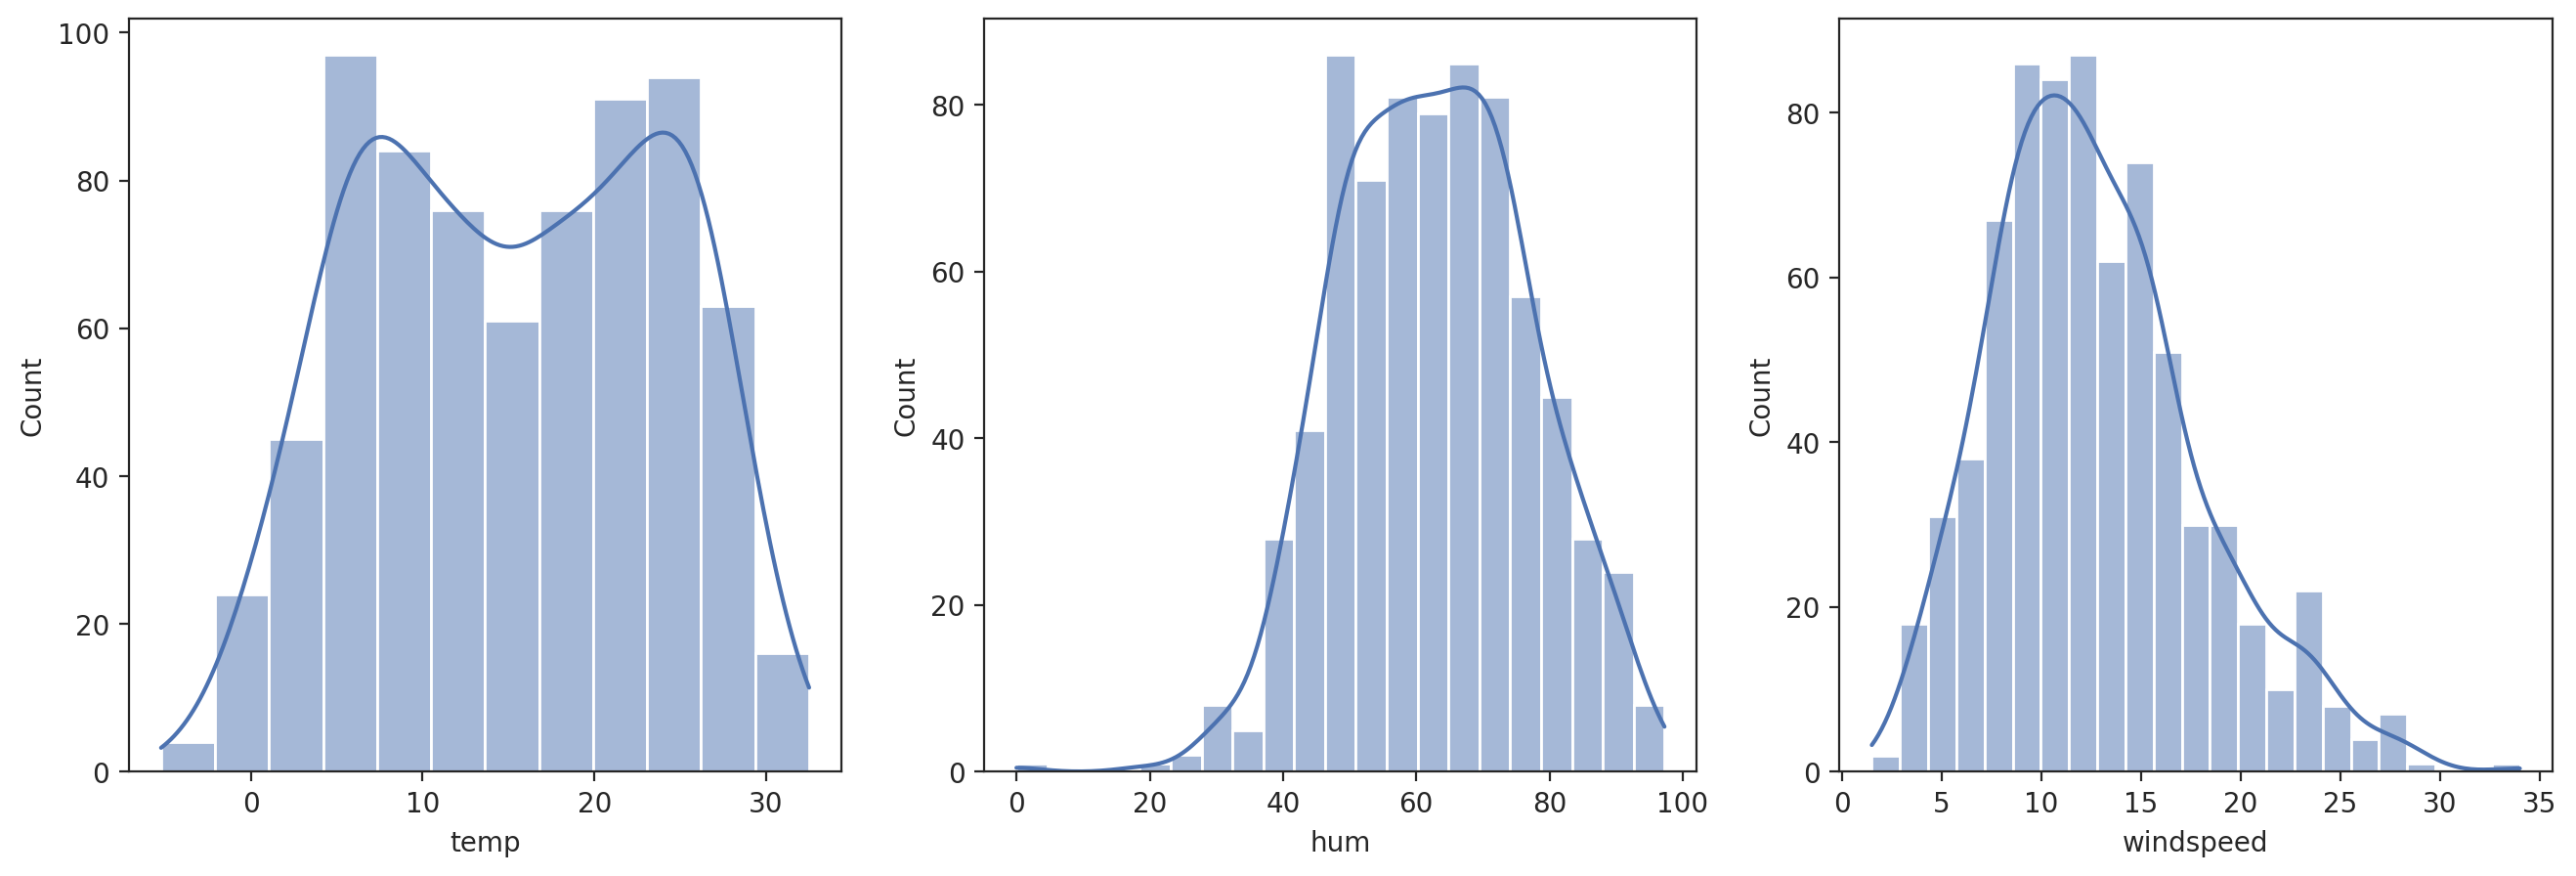

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.histplot(data=bike, x='temp', kde=True, ax=axes[0])
sns.histplot(data=bike, x='hum', kde=True, ax=axes[1])
sns.histplot(data=bike, x='windspeed', kde=True, ax=axes[2])


In [83]:
def Create_pp(X, linear_model=False):
    bin_cat = ['holiday', 'workingday']
    tar_cat = ['season', 'mnth', 'weekday', 'weathersit']
    num = ['yr', 'temp', 'hum', 'windspeed', 'days_since_2011' ]

    if linear_model:
        numeric_transformer = Pipeline(
            steps=[
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False))
            ]
        )

        cat_ohe_transformer = Pipeline(
            steps=[
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'))
            ]
        )

        cat_tar_transformer = Pipeline(
            steps=[
                ('tar', TargetEncoder())  # categories='auto'
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num),
                ('cat_ohe', cat_ohe_transformer, bin_cat),
                ('cat_tar', cat_tar_transformer, tar_cat)
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        )

        return preprocessor
    else:
        # If not linear_model, return X unchanged
        return X


In [86]:
def create_regr_ppln(est, X, linear_model=False):
    """ """
    regr_pipe = Pipeline(
        steps=[
            ("pp", Create_pp(X, linear_model)),
            ("regr", est)
        ]
    )

    return regr_pipe

In [87]:
gbr  = create_regr_ppln(GradientBoostingRegressor(max_depth=3), X_train)
rfr  = create_regr_ppln(RandomForestRegressor(max_depth=8), X_train)
lr   = create_regr_ppln(LinearRegression(), X_train, linear_model=True)
knn = create_regr_ppln(KNeighborsRegressor(n_neighbors=3), X_train)

In [88]:
my_models = [ gbr, rfr, lr ]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
    )

TypeError: Expected sequence or array-like, got <class 'NoneType'>

In [16]:
pipeline = Pipeline(steps=[
    ('pp', FunctionTransformer(Create_pp(X), kw_args={'linear_model': False})),  # Pass preprocessing function with appropriate arguments
    ('regressor', None)  # Regressor (will be replaced in GridSearch)
])

In [17]:


# Define parameter grid for GridSearch
param_grid = [
    {
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7]
    },
    {
        'regressor': [GradientBoostingRegressor()],
        'regressor__n_estimators': [50, 100, 150],
        'regressor__learning_rate': [0.1, 0.01, 0.001]
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 150],
        'regressor__max_depth': [None, 10, 20]
    }
]

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=None,  n_jobs=-1)  # cv is cross-validation folds

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator Pipeline(steps=[('pp', FunctionTransformer(kw_args={'linear_model': False})),
                ('regressor', None)]) does not.